In [7]:
import gym
import numpy as np
import keras
import random
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
import cv2
from collections import deque
import os.path


random.seed(7)

In [8]:
import gym
env = gym.make('Breakout-v0')
env.reset()



def preprocess(observation):
    observation = cv2.cvtColor(cv2.resize(observation, (84, 110)), cv2.COLOR_BGR2GRAY)
    observation = observation[26:110,:]
    return np.reshape(observation,(84,84,1))

# def preprocess(observation):
#     observation = cv2.cvtColor(cv2.resize(observation, (84, 84)), cv2.COLOR_BGR2GRAY)
# #     ret, observation = cv2.threshold(observation,1,255,cv2.THRESH_BINARY)
#     return np.reshape(observation,(84,84,1))





Deep ConvNet class

In [9]:
class DQN():
    def __init__(self, inputWidth=84, inputHeight=84, zSize=4):
        self.model = Sequential()
        model = self.model
        data_format=None
        model.add(Conv2D(32, (8, 8), strides=(4, 4), activation='relu', 
                        input_shape=(inputWidth, inputHeight, 4)))
        model.add(Conv2D(64, (4, 4), strides=(2, 2), activation='relu'))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dense(4))
        
        model.compile(loss='mean_squared_error', optimizer='adam')
        if os.path.exists('breakout-v0-weights-v0.h5'):
            self.loadModel()
            print('loaded nn weights from file')

        print('Initializing random nn')
        
    #passed X and Y buffer to training
        
        
    def saveModel(self):
        self.model.save_weights('breakout-v0-weights-v0.h5')
        
    def loadModel(self):
        self.model.load_weights('breakout-v0-weights-v0.h5')

    def getModel(self):
        return self.model


In [10]:
class replay_Memory():
    def __init__(self, maxSize=2000):
        self.maxSize = maxSize
        self.memory = np.array([])
        
    def addUnit(self, unit):
        if len(self.memory) + 1 > self.maxSize: 
            self.memory = np.append(self.memory[1:len(self.memory)], unit)
        else:
            self.memory = np.append(self.memory, unit)
            
    def getMemory(self):
        return self.memory
    
    
    def getBatch(self, batch_length):
        memlen = len(self.memory)
        if batch_length > memlen:
            return np.random.choice(self.memory, memlen)
        else:
            return np.random.choice(self.memory, batch_length)
            
        

<img src="files/pseudocode.png">

In [ ]:
# EPSILON_EXPLORATION = 0.01
# TARGET_UPDATE_TICK = 0
# TARGET_UDPATE_STEP = 4
# DISCOUNT_CONSTANT = 0.99
# REPEAT_ACTION_N = 4


# for episode in range(1, 1001):
#     totalReward, reward = 0,0
#     state = env.reset()
#     done = False
    
    
#     while not done:
#         nextState, reward, done, info = env.step(random.randint(0, env.action_space.n -1))
#         totalReward += reward
#         env.render()

loaded nn weights from file
Initializing random nn


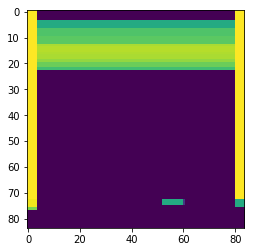

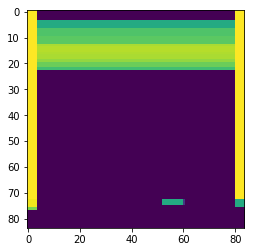

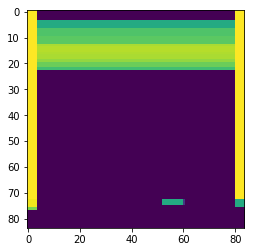

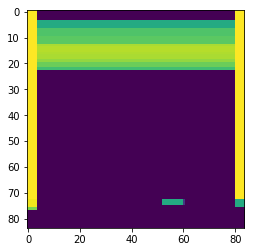

In [ ]:
#class that is representing single transition in replay memory
class Transition():
    
    def __init__(self, observation0, action, reward, observation1, isTerminal):
        self.isTerminal = isTerminal
        self.obs0 = observation0
        self.action = action
        self.reward = reward
        self.obs1 = observation1
    
    def getObs(self, index):
        if index == 0:
            return self.obs0
        elif index == 1:
            return self.obs1
        else:
            raise Excetion('Error', 'Invalid index of observation given in transition getter')

    def isTerminal():
        return self.isTerminal
    
    def getReward(self):
        return self.reward
    
    def getAction(self):
        return self.action
    
        

def get_actions(st, model):
    if len(st) != 4:
        raise Exception('Error', 'stateProcessingError!')

    st = np.dstack((st[0], st[1], st[2], st[3]))
    result = model.predict(np.array([st]))[0]
#     print('prediction', result)
    return result

    

        
    
memory = replay_Memory()

#initialize dqn
q = DQN()

states = []

env.reset()

for i in range (0, 4):
    observation, _, _, _ = env.step(0)
    states.append(preprocess(observation))
    observation0 = preprocess(observation)
#     print("After processing: " + str(np.array(observation0).shape))
    plt.imshow(np.array(np.squeeze(observation0)))
    plt.show()
# print(get_actions(states, q.getModel()))
# print(np.argmax(get_actions(states, q.getModel())[0]))



#initialize target dqn
q_target_model = keras.models.clone_model(q.getModel())
q_target_model.set_weights(q.getModel().get_weights())


#what percentage of actions are random (improves exploartion rate of the algorithm)


#constants

EPSILON_EXPLORATION_START = 0.010
epsilon = EPSILON_EXPLORATION_START
EPSILON_EXPLORATION_END = 0.05
EXP_DECAY_FRAMES = 10
epsilon_change = (EPSILON_EXPLORATION_START - EPSILON_EXPLORATION_END) / EXP_DECAY_FRAMES
TARGET_UDPATE_STEP = 4
DISCOUNT_CONSTANT = 0.99
REPEAT_ACTION_N = 4

rewards = []

iter = 0
while True:

    TARGET_UPDATE_TICK = 0
    totalReward = 0
    tick = 0
    lastAction = env.action_space.sample()
    lives = 5
    
    env.reset()
    done = False
    
    recentStates = deque([], maxlen=4)
    
    #print('new episode', episode)
    
    iter += 1
    if iter % 25 == 0: 
        q.saveModel()
        
    while not done and lives != 1:

        #repeat 3 same actions on same frame
        if tick < REPEAT_ACTION_N:
            observation, reward, done, info = env.step(lastAction)
            lives = info['ale.lives']
            totalReward += reward
            recentStates.append(preprocess(observation))
            tick += 1
#             print("repeat action", lastAction)
        else:
            randval = random.uniform(0, 1)

            #perform random action
            if randval <= epsilon:
                lastAction = env.action_space.sample()
                observation, reward, done, info = env.step(lastAction) 
                totalReward += reward
                lives = info['ale.lives']

                recentStates.append(preprocess(observation))
#                 print('doing random action', lastAction)

            #perform DQN action
            else:
                
                #get optimal action
                
                optimal_action = np.argmax(get_actions(recentStates, q.getModel()))
#                 print('recentstates LEN, ', len(recentStates))
#                 print('optimal action', optimal_action)
                #execute optimal action
                observation, reward, done, info = env.step(optimal_action)
                lives = info['ale.lives']
                totalReward += reward
                
                
                #update last action
                lastAction = optimal_action
                
                obs_t0 = recentStates.copy()
                
                recentStates.append(preprocess(observation))
                
                obs_t1 = recentStates.copy()

                
                #save transition in replay memory
                transition = Transition(obs_t0, optimal_action, reward, obs_t1, isTerminal=done or lives != 5)
                
                memory.addUnit(transition)
                
                #batch = [{ob1, an, r, ob2}...]
                batch = memory.getBatch(32)
                
                if len(memory.getMemory()) < 100:
                   continue
                #get X for training
                X = []
                for sample in batch:
#                     print('X')
                    st = sample.getObs(0)
                    train_val = np.dstack((st[0], st[1], st[2], st[3]))
#                     print('train_val', train_val.shape)
                    X.append(train_val)
                X = np.array(X)
                
                #get Y for training
                Y = []
                #get the correct Y values
                for sample in batch:
                    
                    sample_action = sample.getAction()
                    prediction = get_actions(sample.getObs(0), q.getModel())
#                     print('y0', prediction)
                    
                    # set target as r
                    if sample.isTerminal:
#                         print('sample action', sample_action)
#                         print('reward', sample.getReward())
                        prediction[sample_action] = sample.getReward()
                        
                    #set target as rt + discount_factor*max(Q(st + 1, a_))    
                    else:
                        max_actionVal = np.max( get_actions(sample.getObs(1), q_target_model) )
#                         print('max_actionVal', max_actionVal)
                        q_value = sample.getReward() + DISCOUNT_CONSTANT * max_actionVal
#                         print(q_value)
                        prediction[sample_action] = q_value
                        
#                     print('prediction Updated', prediction)
                    Y.append(prediction)

#                 print('Y', Y)
                Y = np.array(Y)
                    
                #perform gradient step update
                q.getModel().fit(x = X, y = Y, verbose=0)
                
                #every TARGET_UDPATE_STEP step copy weights to target network
                if TARGET_UPDATE_TICK >= TARGET_UDPATE_STEP:
                    TARGET_UPDATE_TICK = 0
                    q_target_model.set_weights(q.getModel().get_weights())
                TARGET_UPDATE_TICK += 1
            tick = 0
        env.render()
    rewards.append(totalReward)
env.close()
    
    
#plot all rewards
plt.plot(rewards)
plt.ylabel('reward')
plt.xlabel('episode')
plt.show()


In [ ]:
import numpy as np

In [ ]:
min(0,1)